# Justin Zarkovacki 2/28/2023

# Transfer Learning Notebook

# Prepare imports

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import tqdm
import os
import glob
import sys

from keras import models, backend as K
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix

print("Done!")

Done!


# Function Definitions and Variables

In [2]:
epochs = 12
img_rows, img_cols = 28, 28  # Image dimensions

def load(f):
    return np.load(f)['arr_0']
    
def initialize_data(train_im_file, test_im_file, train_lb_file, test_lb_file):
    train_images = load(train_im_file)
    test_images = load(test_im_file)
    train_labels = load(train_lb_file)
    test_labels = load(test_lb_file)
    
    if K.image_data_format() == 'channels_first':
        train_images = train_images.reshape(train_images.shape[0], 1, img_rows, img_cols)
        test_images = test_images.reshape(test_images.shape[0], 1, img_rows, img_cols)
        input_shape = (1, img_rows, img_cols)
    else:
        train_images = train_images.reshape(train_images.shape[0], img_rows, img_cols, 1)
        test_images = test_images.reshape(test_images.shape[0], img_rows, img_cols, 1)
        input_shape = (img_rows, img_cols, 1)

    train_images = train_images.astype('float32')
    test_images = test_images.astype('float32')
    train_images /= 255
    test_images /= 255
    print('{} train samples, {} test samples'.format(len(train_images), len(test_images)))
    
    return tuple([train_images, test_images, train_labels, test_labels, input_shape])

# Helper to create the graphics
def create_visuals(graph_title, model_hist, test_images, test_labels):
    accuracy_data = model_hist.history['accuracy']
    val_accuracy_data = model_hist.history['val_accuracy']

    lower_bound = min(min(accuracy_data), min(val_accuracy_data))

    plt.plot(accuracy_data, label='Train Accuracy')
    plt.plot(val_accuracy_data, label = 'Validation Accuracy')

    plt.title(graph_title)
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim([lower_bound - 0.01, 1])
    plt.legend(loc='lower right')

    print(accuracy_data[-1])
    print(val_accuracy_data[-1])
#     test_loss, test_acc = model_hist.evaluate(test_images, test_labels, verbose=2)

print("Done!")

Done!


## Load Data

In [3]:
prefix = 'C:\\Users\\LifeH\\SoftwareDevelopment\\KanjiCharacterRecognition\\Datasets\\'
datasets = {
    "km_tr_i" : prefix + 'Kuzushiji-MNIST - train-imgs.npz',
    "km_te_i" : prefix + 'Kuzushiji-MNIST - test-imgs.npz',
    "km_tr_l" : prefix + 'Kuzushiji-MNIST - train-labels.npz',
    "km_te_l" : prefix + 'Kuzushiji-MNIST - test-labels.npz',
    "k49_tr_i" : prefix + 'Kuzushiji-49 - train-imgs.npz',
    "k49_te_i" : prefix + 'Kuzushiji-49 - test-imgs.npz',
    "k49_tr_l" : prefix + 'Kuzushiji-49 - train-labels.npz',
    "k49_te_l" : prefix + 'Kuzushiji-49 - test-labels.npz',
}

kanji_path = 'C:\\Users\\LifeH\\SoftwareDevelopment\\KanjiCharacterRecognition\\Datasets\\final_dataset'
project_prefix = "C:\\Users\\LifeH\\SoftwareDevelopment\\KanjiCharacterRecognition\\"

In [4]:
# Load KMNIST Data
dataset = initialize_data(datasets["km_tr_i"], datasets["km_te_i"], datasets["km_tr_l"], datasets["km_te_l"])
kmnist_train_images = dataset[0]
kmnist_test_images = dataset[1]
kmnist_train_labels = dataset[2]
kmnist_test_labels  = dataset[3]
kmnist_input_shape = dataset[4]
kmnist_classes = 10
kmnist_epochs = 15

60000 train samples, 10000 test samples


In [5]:
# Load Kuzushiji-49 Data
dataset = initialize_data(datasets["k49_tr_i"], datasets["k49_te_i"], datasets["k49_tr_l"], datasets["k49_te_l"])
k49_train_images = dataset[0]
k49_test_images = dataset[1]
k49_train_labels = dataset[2]
k49_test_labels  = dataset[3]
k49_input_shape = dataset[4]
k49_classes = 49
k49_epochs = 15

batches = 128
num_trials = 15

print("Done!")

232365 train samples, 38547 test samples
Done!


In [5]:
# Load Kanji data
kanji_classes = 150
kanji_epochs = 15
im_size = (64, 64)
bs = 1

kanji_val = tf.keras.utils.image_dataset_from_directory(kanji_path, validation_split=0.3, seed=222,
                  subset="validation", color_mode="grayscale", image_size=im_size, batch_size=bs)

kanji_class_names = kanji_val.class_names

print("Done!")

Found 70599 files belonging to 150 classes.
Using 21179 files for validation.
Done!


In [6]:
# Normalize data
normalization_layer = tf.keras.layers.Rescaling(1./255)

# Rescale Kanji training data
normalized_kanji_val = kanji_val.map(lambda x, y: (normalization_layer(x), y))

# Optimize Kanji dataset
AUTOTUNE = tf.data.AUTOTUNE

# Kanji Optimization
kanji_val = kanji_val.cache().prefetch(buffer_size=AUTOTUNE)

print("Done!")

Done!


# Define the Ensemble Model Design

In [5]:
class EnsembleClassifier:
    trained_models = {}
    missclassifications = {}
    y_true = []
    y_pred = []


    def __init__(self, working_dir) -> None:
        for name in glob.glob(os.path.join(working_dir, "*")):
            model_dir = os.path.join(working_dir, name)
            try:
                self.trained_models[name] = models.load_model(model_dir)
                print(f'LOADING MODEL: {name}\n')
                print('')
            except Exception as e:
                print("here2")
                print(e)
            

    # boolean is_h5 determines the size that the data is reshaped into
    def predict(self, element, is_h5):
        model_predictions = [None] * len(self.trained_models.keys())

        # Use each individual model to predict
        for i, (name, model) in enumerate(self.trained_models.items()):
            if is_h5:
                model_predictions[i] = model.predict(element.reshape(1, 28, 28))
            else:
                # model_predictions[i] = model.predict(element.reshape(1, 64, 64))
                model_predictions[i] = model.predict(element)

        model_predictions = np.sum(np.array(model_predictions), axis=0)

        return np.argmax(model_predictions)

    def h5_validate(self, images, labels, h5):
        for i, element in tqdm.tqdm(enumerate(images), ncols=100, desc='Validation Progress'):
            true_label = labels[i]
            pred_label = self.predict(element, h5)

            self.y_true.append(true_label)
            self.y_pred.append(pred_label)

            if pred_label != true_label:
                # print(f'Model confused: {pred_label} for {true_label}')

                if pred_label in self.missclassifications.keys():
                    self.missclassifications[pred_label] += 1
                else:
                    self.missclassifications[pred_label] = 1
        

    def image_validate(self, validation_data, labels, h5):
        for i, (element, label) in tqdm.tqdm(enumerate(validation_data), ncols=100, desc='Validation Progress'):
            true_label = labels[label[0].numpy()]
            prediction = self.predict(element, h5)
            pred_label = labels[prediction]

            self.y_true.append(true_label)
            self.y_pred.append(pred_label)

            if pred_label != true_label:
                # print(f'Model confused: {pred_label} for {true_label}')

                if pred_label in self.missclassifications.keys():
                    self.missclassifications[pred_label] += 1
                else:
                    self.missclassifications[pred_label] = 1

    
    def print_results(self, num_samples, output_path):
      incorrect = 0
      for val in self.missclassifications.values():
          incorrect += val

      print(f'Number of misclassifications: {incorrect}')
      print(f'Validation Accuracy: {1 - (incorrect / num_samples)}\n')

      with open(output_path, 'w') as f:
          f.write(f'Number of misclassifications: {incorrect}\n')
          f.write(f'Validation Accuracy: {1 - (incorrect / num_samples)}\n')
          f.close()

    
    def create_confusion_matrix(self, labels, output_path):
        conf_matrix = confusion_matrix(self.y_true, self.y_pred)
        df_cm = pd.DataFrame(conf_matrix, 
                                index=[i for i in labels], 
                                columns=[i for i in labels])

        df_cm.to_csv(output_path)
        plt.figure(figsize=(40,40))
        ax = sns.heatmap(df_cm, annot=True, vmax=8)
        ax.set(xlabel="Predicted", ylabel="True", title=f'Ensemble Model Confusion Matrix for: {len(labels)} classes')
        ax.xaxis.tick_top()
        plt.xticks(rotation=90)
        plt.show()
        print('')
            

    def demo(self, validation_data):
        for i, (element, label) in enumerate(validation_data):
            true_label = validation_data.class_names[label[0].numpy()]
            prediction = self.predict(element)
            pred_label = validation_data.class_names[prediction]
            print(f'PRED: {pred_label}')
            print(f'TRUE: {true_label}')
            if pred_label != true_label:
                print(f'Model confused: {pred_label} for {true_label}')

            self.plot_image(element.numpy()[0].astype("uint8"), true_label)

            if i >= 10:
                break
    

    def plot_image(self, image, label):
        plt.figure(figsize=(3, 3))
        plt.imshow(image, cmap='gray', vmin=0, vmax=255)
        plt.title(label)
        plt.axis("off")
        plt.show()
        

    def plot_missclassifications(self):
        plt.bar(self.missclassifications.keys(), 
                self.missclassifications.values(), 
                1.0, color='r')
        plt.show()

# Run KMNIST Ensemble

In [6]:
kmnist_models_path = project_prefix + "kmnist_models\\"
training_output_path = project_prefix + "Outputs\\EnsembleOutputs\\KMNIST_Ensemble_Output.txt"

if __name__ == "__main__":

    orig_stdout = sys.stdout
    with open(training_output_path, 'w') as f:
        sys.stdout = f
        kmnist_ensemble = EnsembleClassifier(kmnist_models_path)
        kmnist_ensemble.h5_validate(kmnist_test_images, kmnist_test_labels, True)
        sys.stdout = orig_stdout
        f.close()

Validation Progress: 10000it [13:49, 12.06it/s]


Number of misclassifications: 382
Validation Accuracy: 0.9618



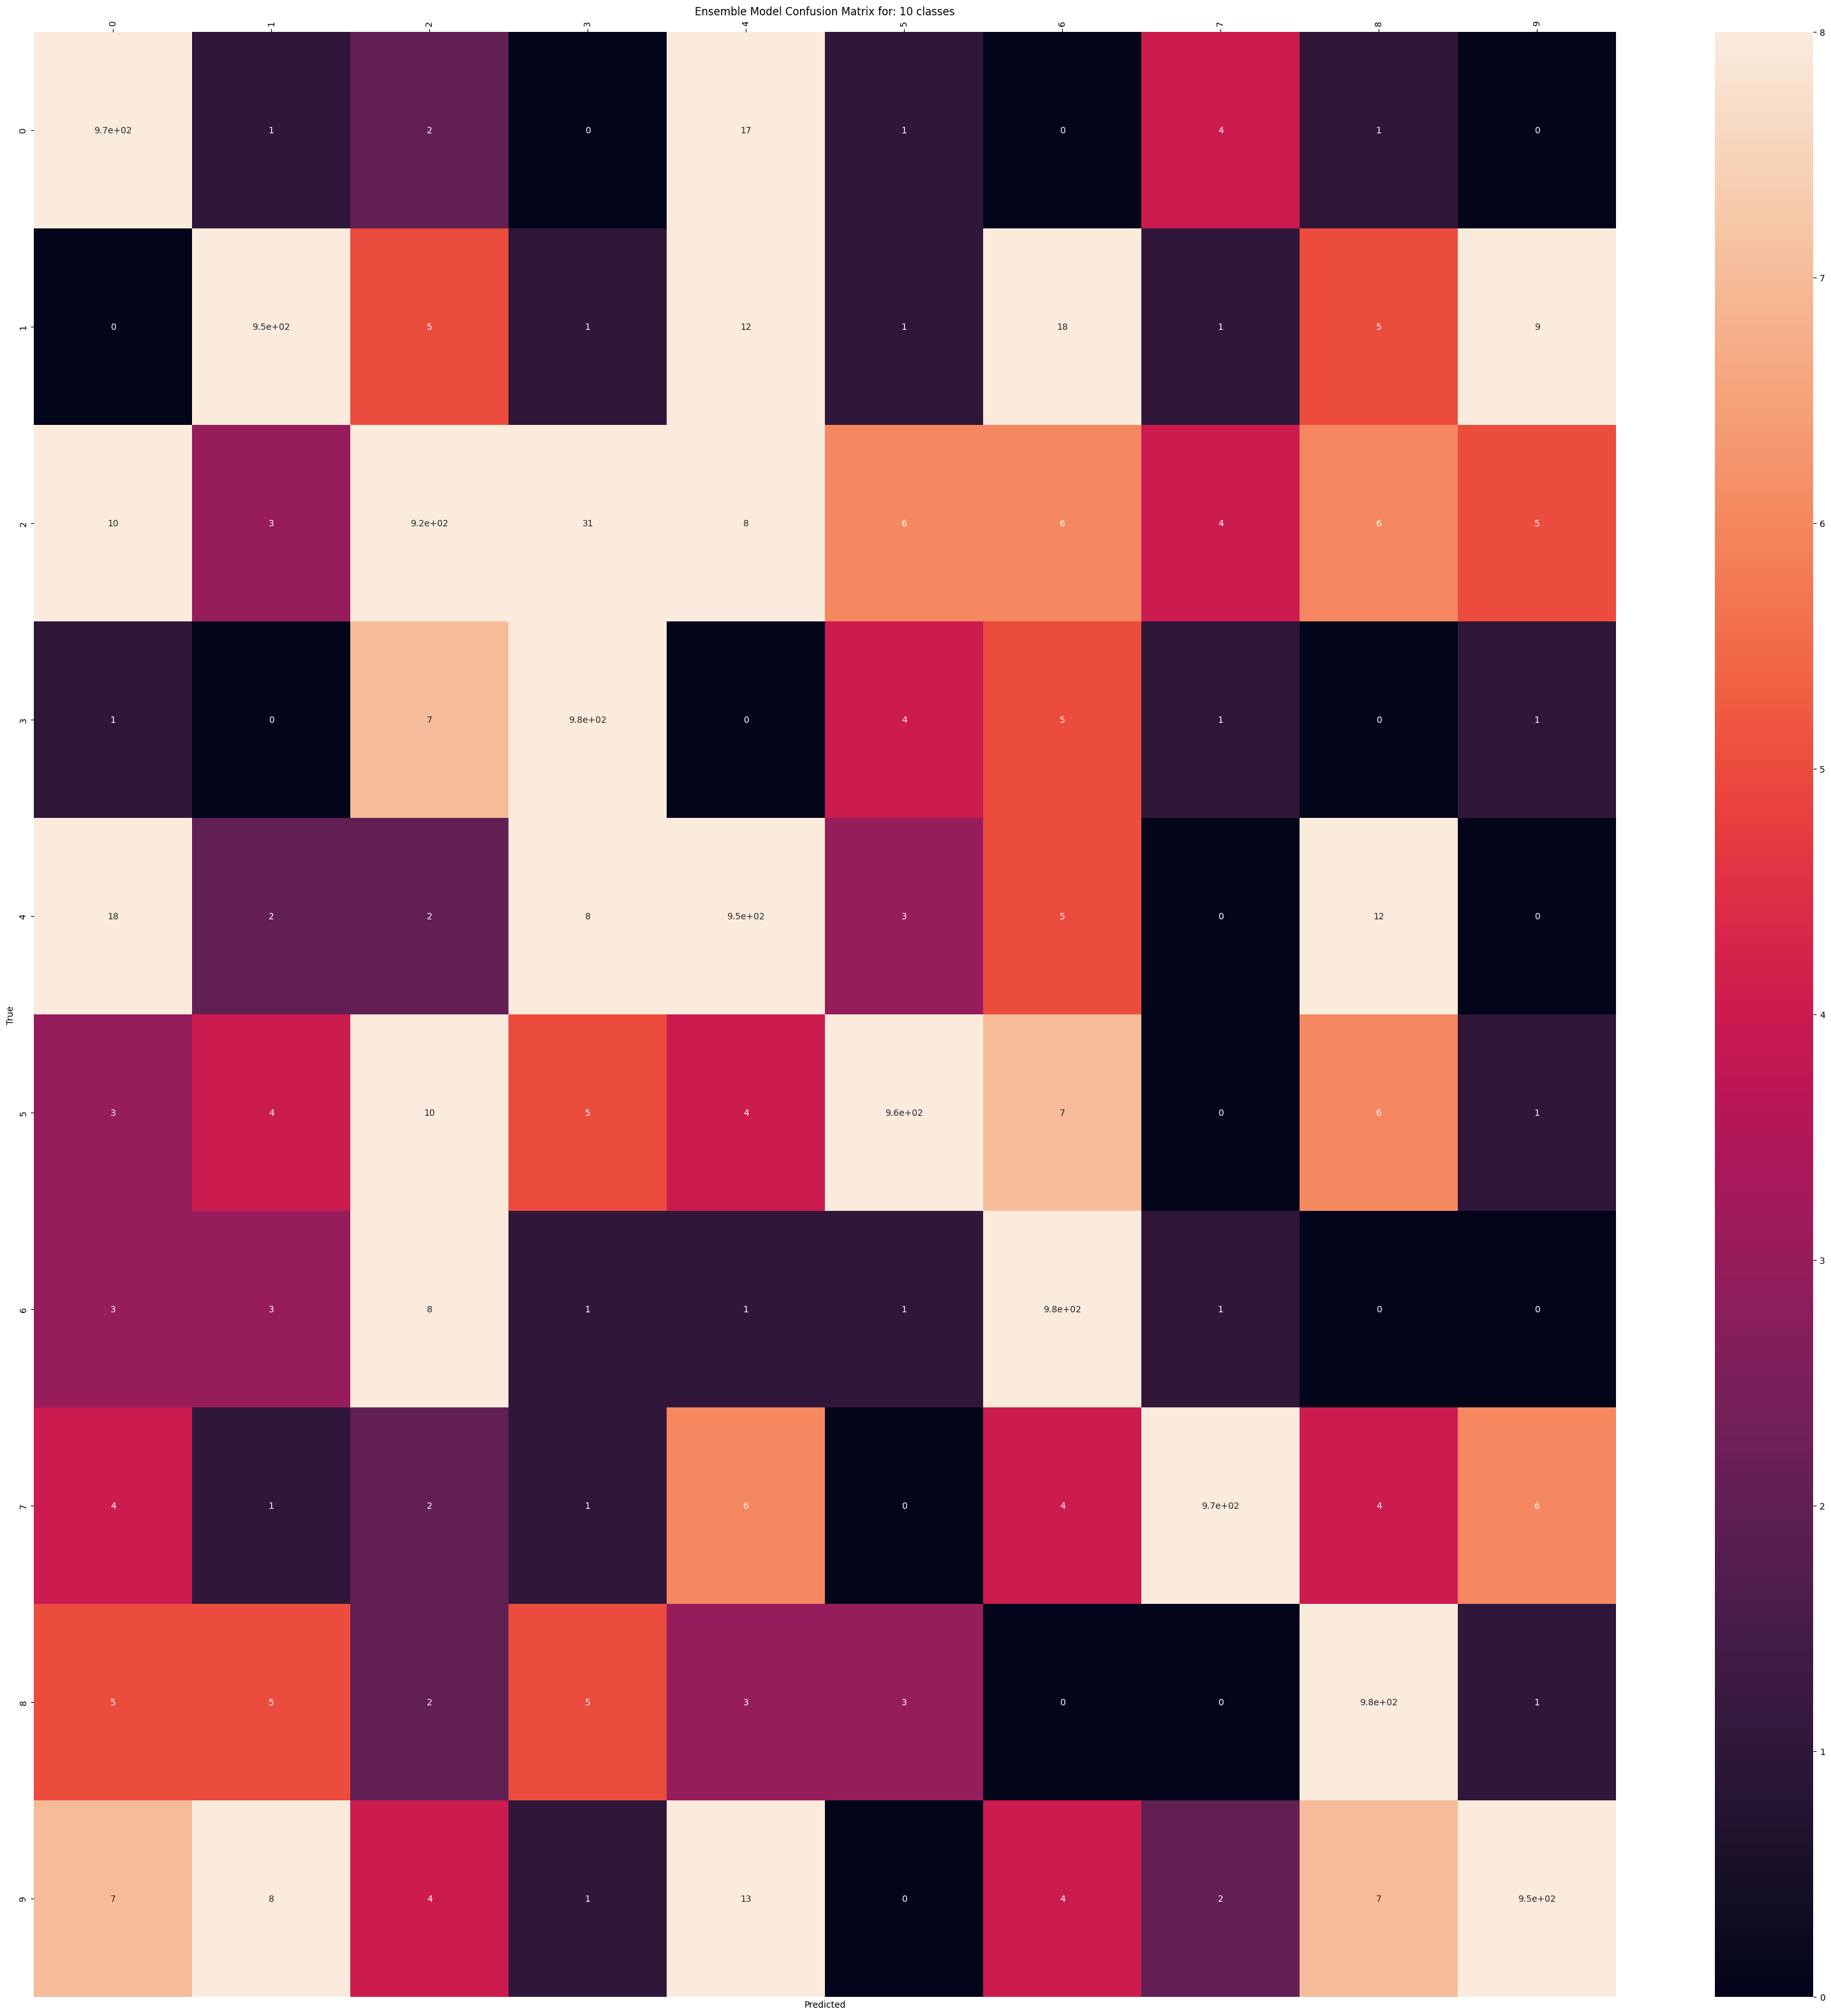

In [7]:
results_output_path = project_prefix + "EnsembleModelResults\\KMNISTResults.txt"    
csv_output_path = project_prefix + "EnsembleModelResults\\KMNISTConfusionMatrix.csv"
kmnist_labels = [str(i) for i in range(10)]

kmnist_ensemble.print_results(len(kmnist_test_labels), results_output_path)
kmnist_ensemble.create_confusion_matrix(kmnist_labels, csv_output_path)

# Run K49 Ensemble

In [7]:
k49_models_path = project_prefix + "k49_models\\"
training_output_path = project_prefix + "Outputs\\EnsembleOutputs\\K49_Ensemble_Output.txt"

if __name__ == "__main__":
    orig_stdout = sys.stdout
    with open(training_output_path, 'w') as f:
        sys.stdout = f
        k49_ensemble = EnsembleClassifier(k49_models_path)
        k49_ensemble.h5_validate(k49_test_images, k49_test_labels, True)
        sys.stdout = orig_stdout
        f.close()

Validation Progress: 38547it [1:02:33, 10.27it/s]


Number of misclassifications: 2029
Validation Accuracy: 0.9473629595039822



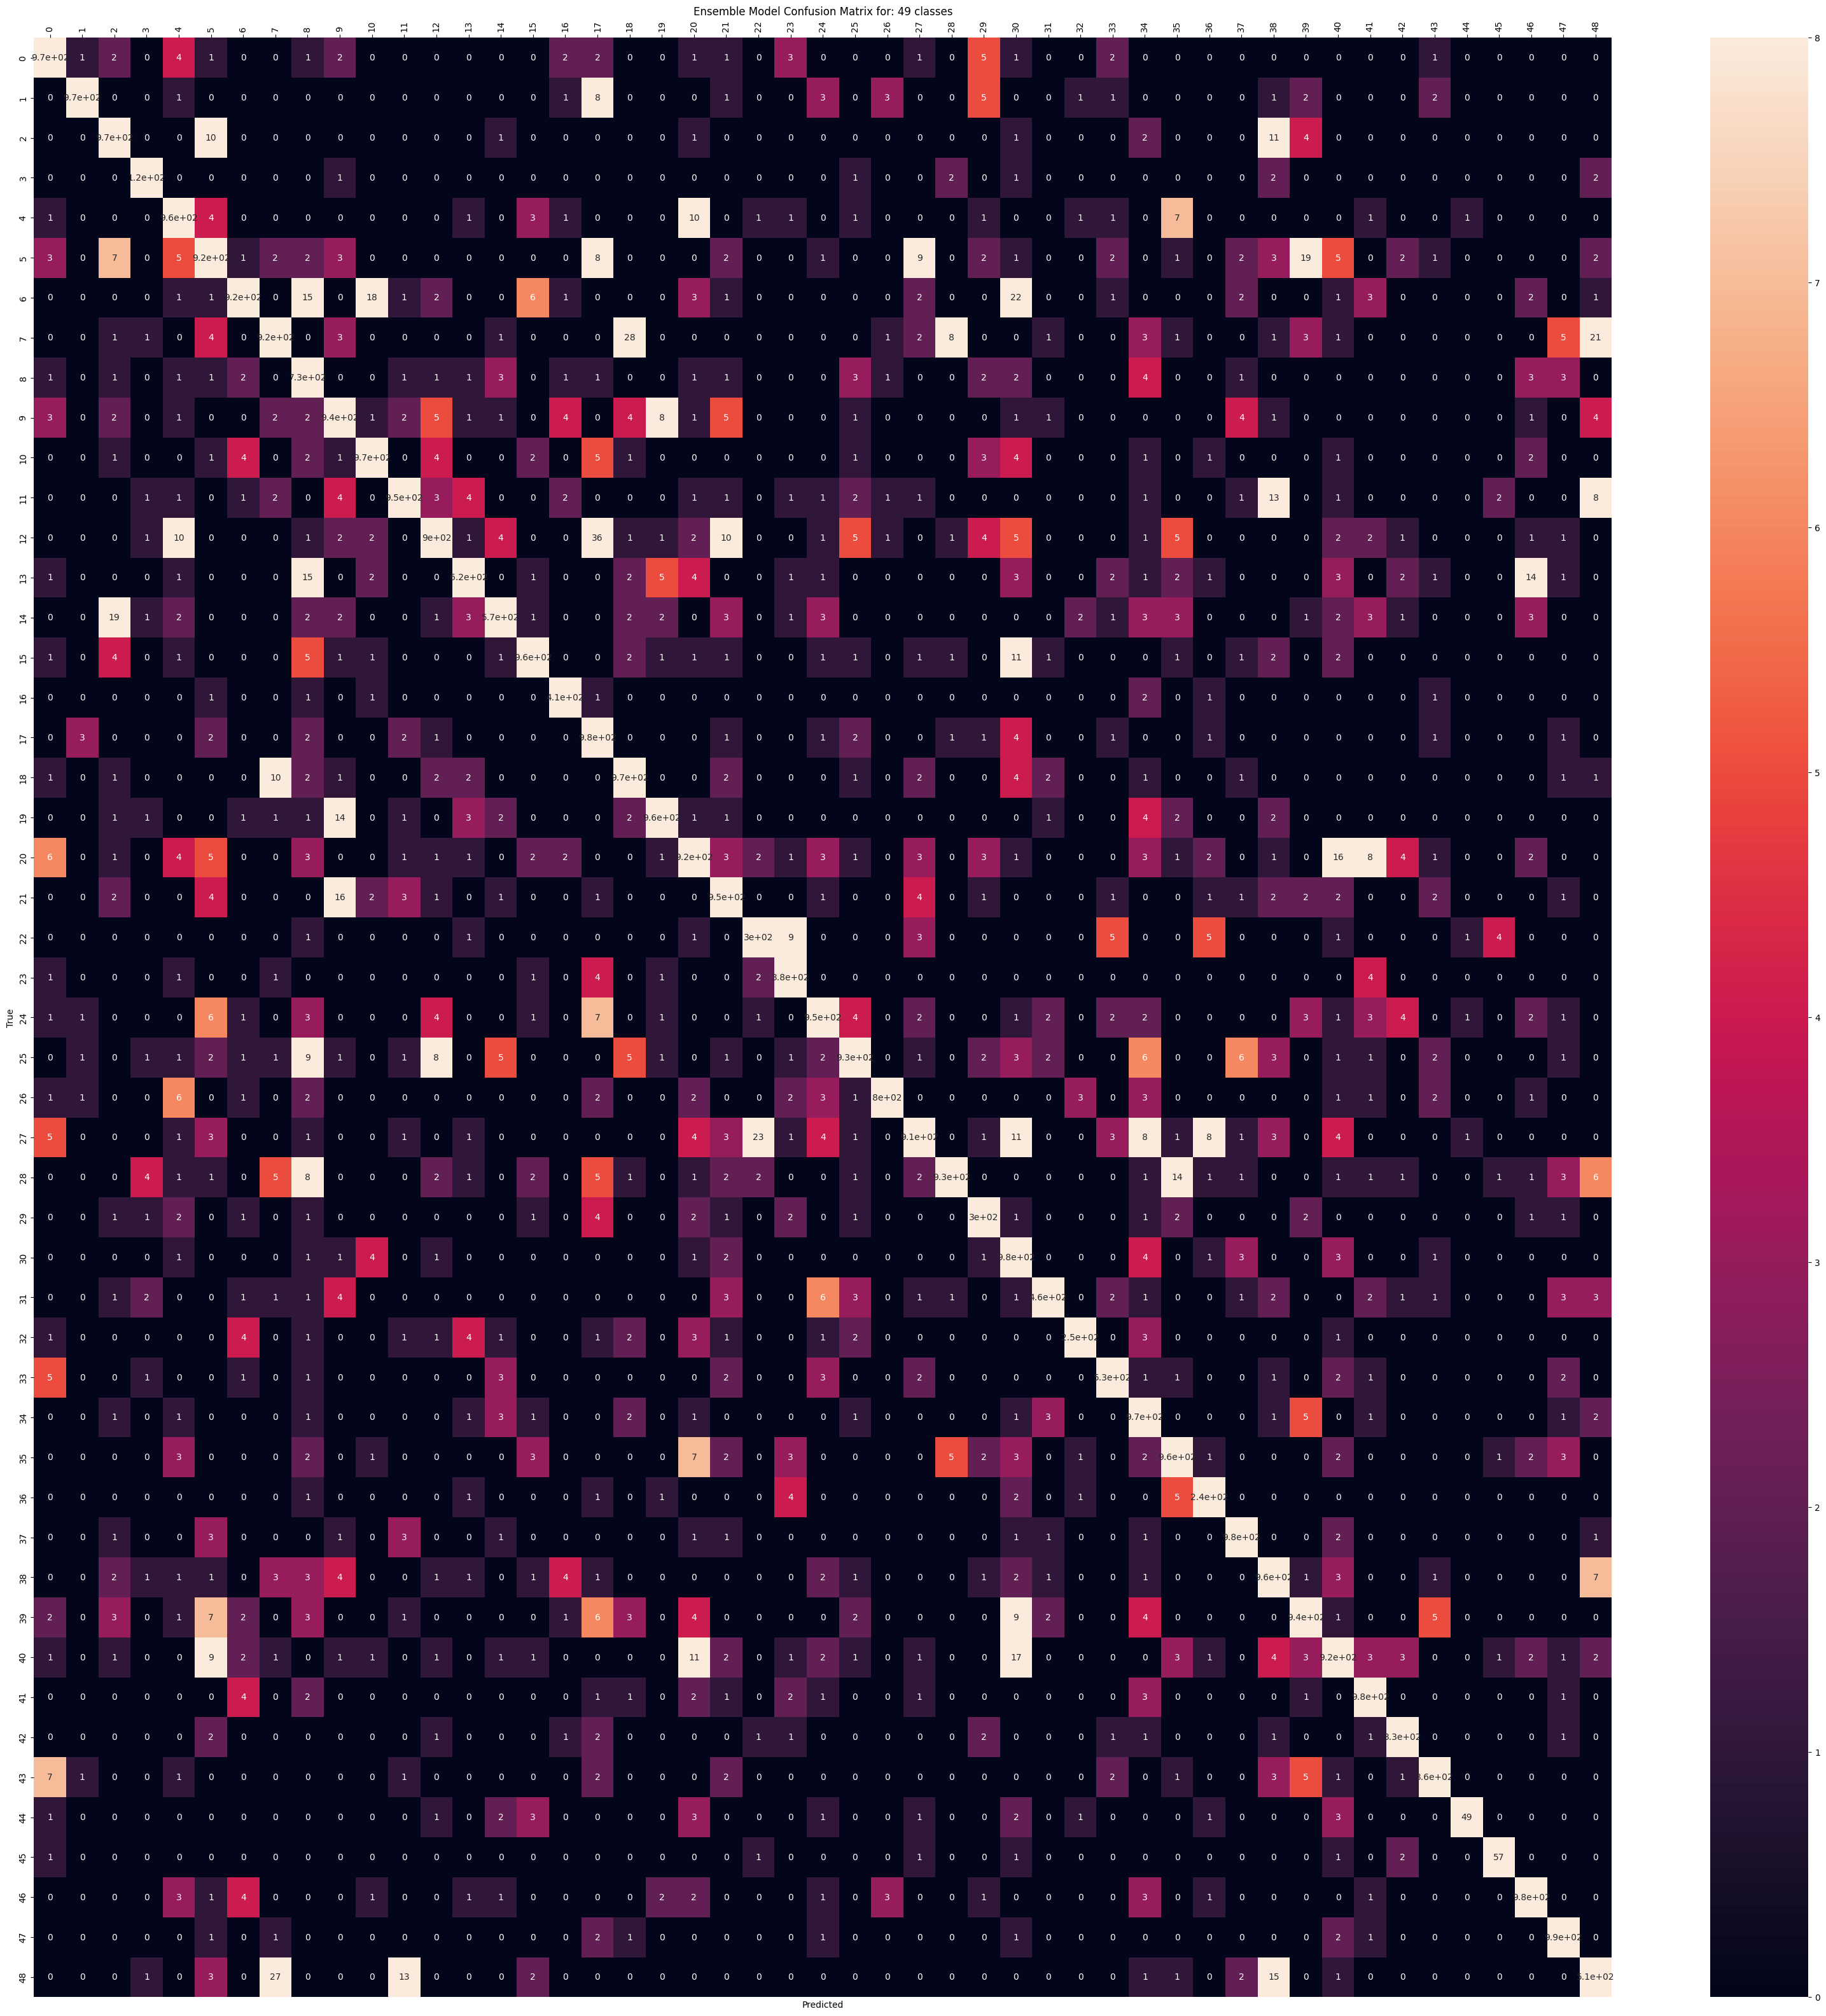

In [8]:
results_output_path = project_prefix + "EnsembleModelResults\\K49Results.txt"
csv_output_path = project_prefix + "EnsembleModelResults\\K49ConfusionMatrix.csv"
k49_labels = [str(i) for i in range(49)]

k49_ensemble.print_results(len(k49_test_labels), results_output_path)
k49_ensemble.create_confusion_matrix(k49_labels, csv_output_path)

# Run Kanji Ensemble

In [8]:
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()

In [9]:
kanji_models_path = project_prefix + "kanji_models\\"
training_output_path = project_prefix + "Outputs\\EnsembleOutputs\\Kanji_Ensemble_Output.txt"

orig_stdout = sys.stdout
with open(training_output_path, 'w') as f:
    sys.stdout = f
    kanji_ensemble = EnsembleClassifier(kanji_models_path)
    kanji_ensemble.image_validate(kanji_val, kanji_class_names, False)
    sys.stdout = orig_stdout
    f.close()


Validation Progress: 21179it [29:17, 12.05it/s]


Number of misclassifications: 1270
Validation Accuracy: 0.9400349402710232



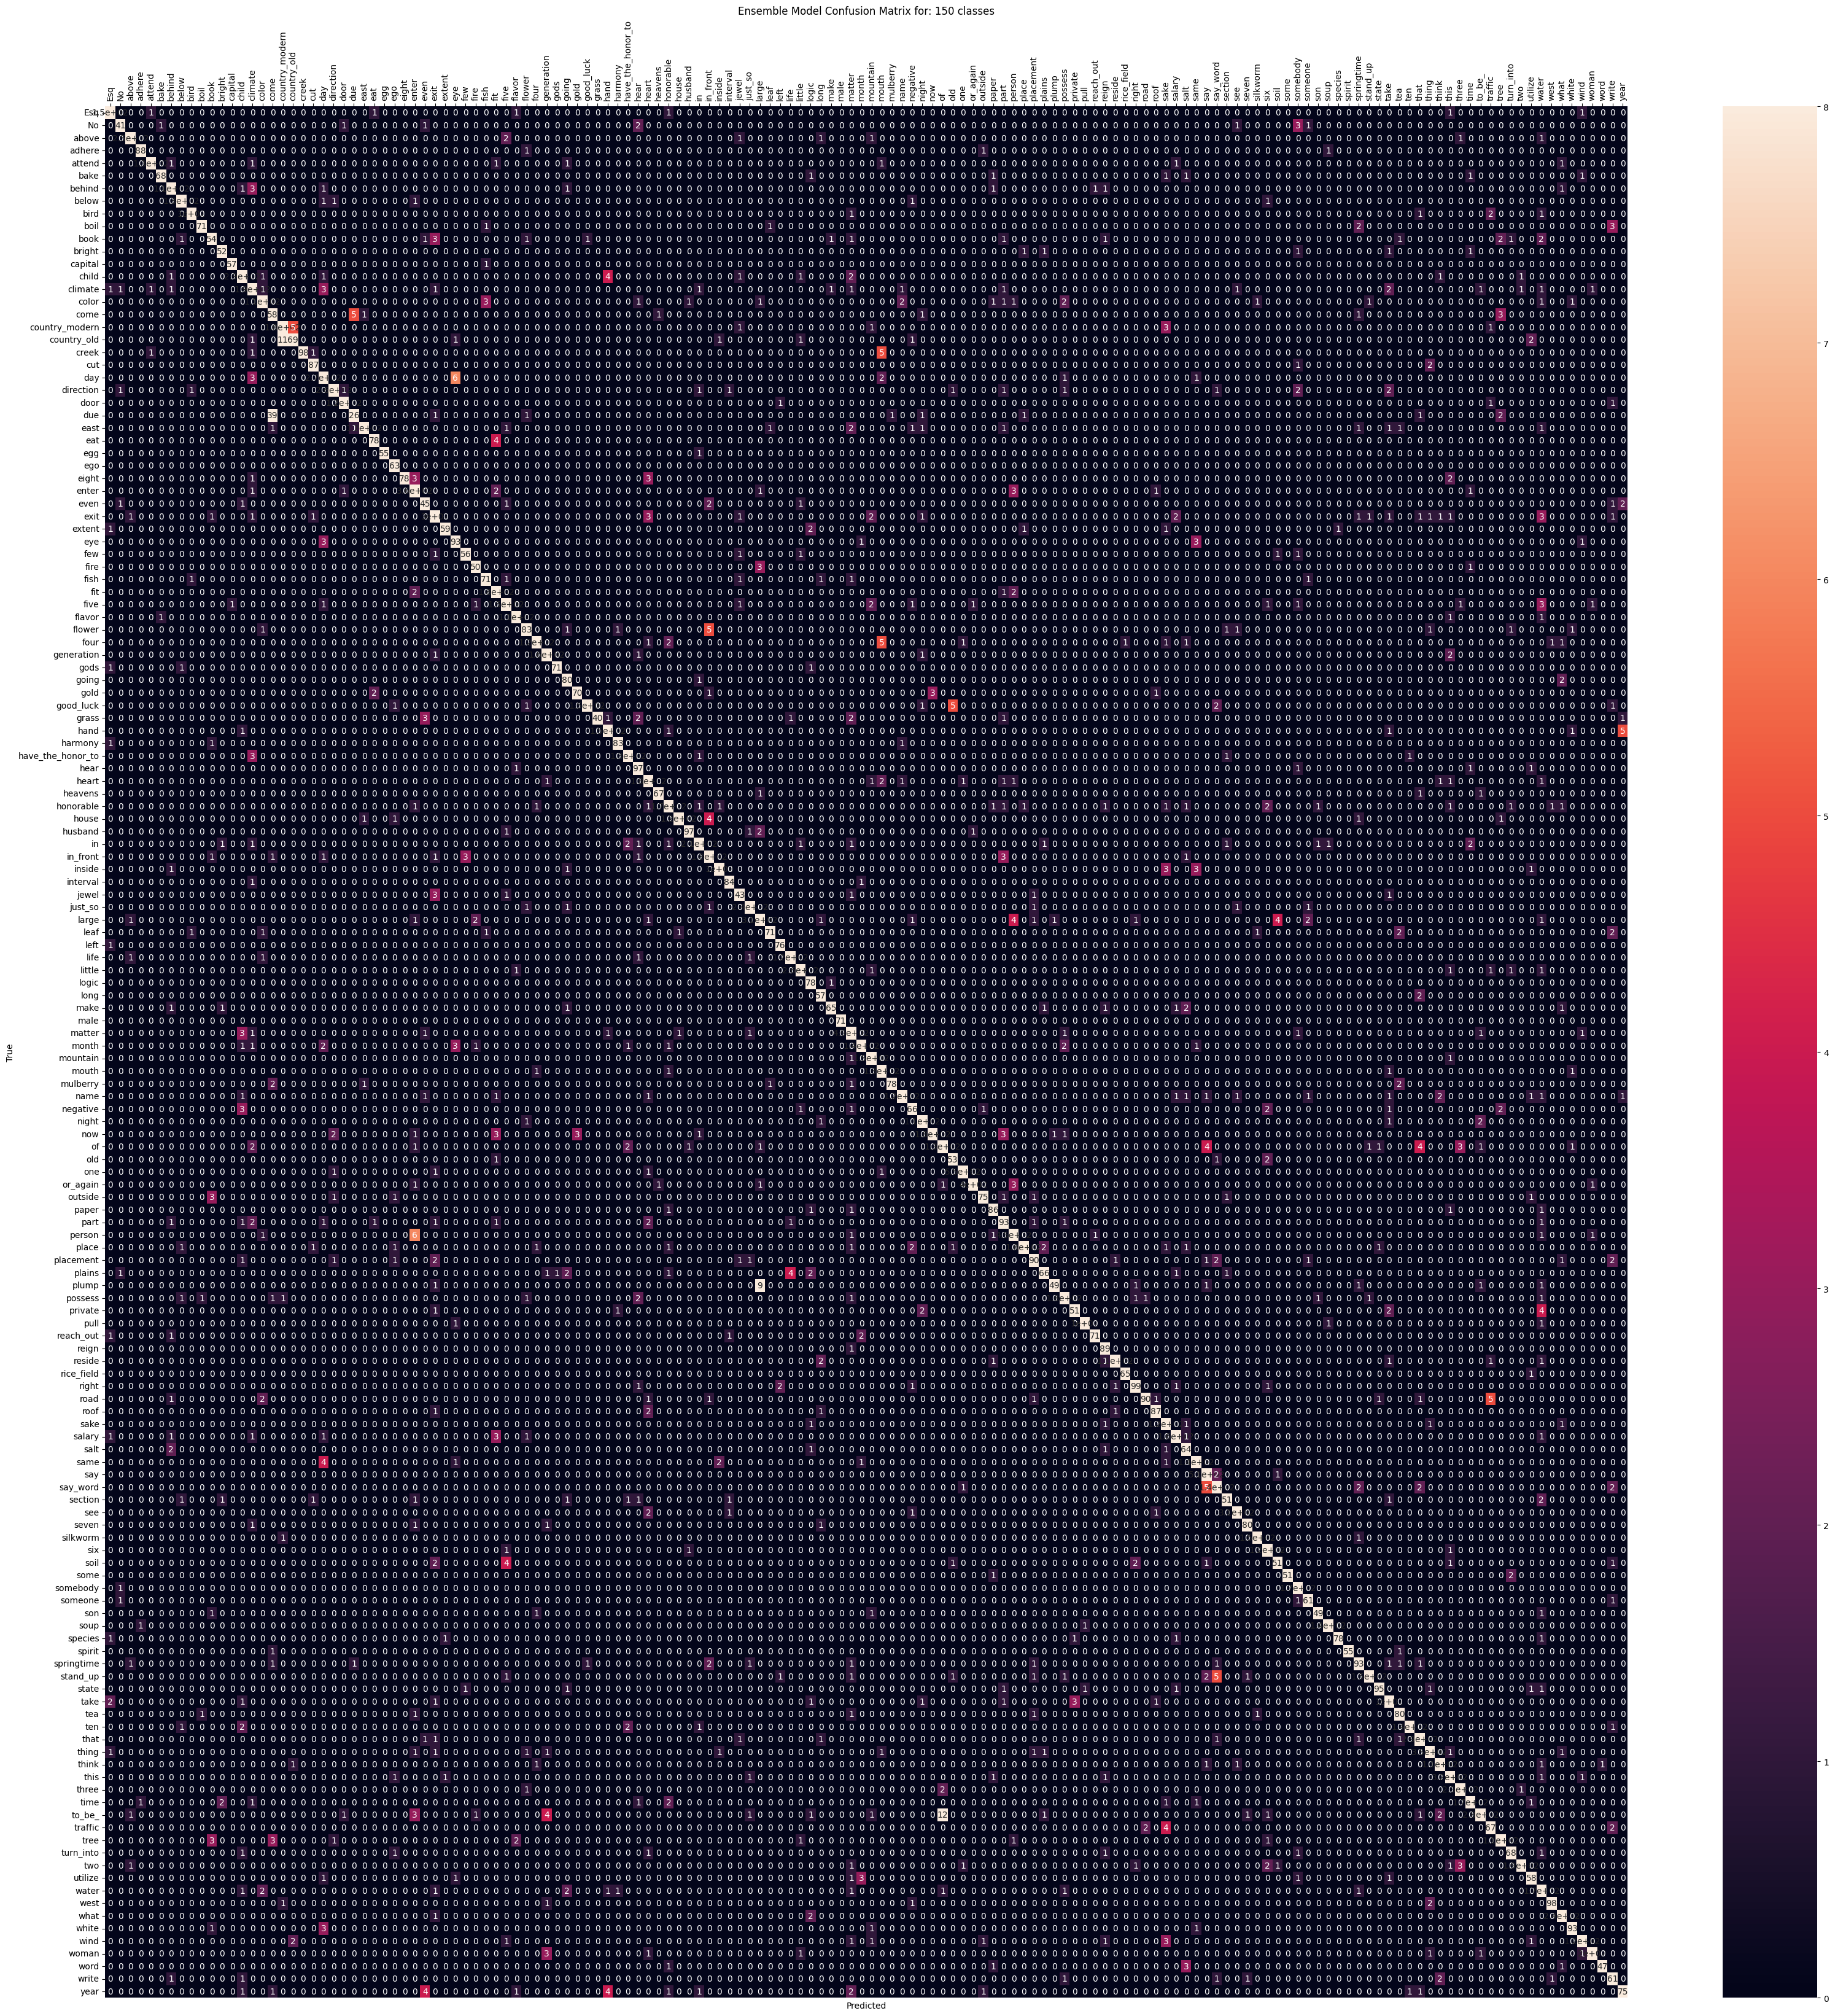

In [10]:
results_output_path = project_prefix + "EnsembleModelResults\\KanjiResults.txt"
csv_output_path = project_prefix + "EnsembleModelResults\\KanjiConfusionMatrix.csv"

kanji_ensemble.print_results(len(kanji_val), results_output_path)
kanji_ensemble.create_confusion_matrix(kanji_class_names, csv_output_path)